<a href="https://colab.research.google.com/github/officalLB/Sombola/blob/main/Automatic_Classification_Of_Key_Words_Associated_with_articles_on_Unza_journals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business Understanding


## 1.1 Problem Statement
Currently, keywords associated with research articles in UNZA journals are not automatically organized or classified. This makes it difficult for researchers, students, and librarians to quickly identify relevant articles or track research trends. A manual process is time-consuming, inconsistent, and limits the usefulness of the institutional repository. Navigation of journals will be a piece of cake!

## 1.2 Business Objectives
The goal of this project is to build a system that can automatically classify keywords from articles into meaningful categories (e.g., *Agriculture, Medicine, Computer Science*).  

From a real-world perspective, success means:
- Improving searchability and retrieval of research articles.
- Helping researchers discover related works faster.
- Supporting administrators in analyzing research output trends at UNZA.

##1.3 Data Mining Goal
  
  The technical approach to achieving these objectives is structured into the following data mining goals:

   1.**Classification Model Development:** A classification model will be built to  categorize article keywords into predefined classes.

  2.**Text Preprocessing:** The raw text data will be prepared for machine learning using standard preprocessing techniques, including tokenization, stop-word removal, and TF-IDF (Term          Frequency-Inverse Document Frequency) for vectorization.

  3.**Algorithm Experimentation:** The performance of several classification algorithms will be evaluated to determine the most effective one. The algorithms to be tested include Naïve          Bayes,   Support Vector Machines (SVM), and Decision Trees.
  
  To wrap things up, the main goal of this project is to build a machine learning model that can automatically classify article keywords. We've broken the work down into two key           parts. First, we'll focus on data preparation by cleaning the text using tokenization and stop-word removal, and then we'll use TF-IDF to turn everything into numbers for the models     to work with.
  
  For the second part, we'll experiment with different algorithms like Naïve Bayes, SVM, and Decision Trees. By testing them with metrics like precision and F1-score, then we'll           figure out which one is the most accurate. We're hoping that by following these steps, we can successfully create a model that not only classifies keywords effectively but also          shows we've got a solid grasp of the data mining process.

   Summary: The workflow involves two main stages.
  First, text preprocessing to clean and transform raw keywords into numerical representations.
  Second, experimentation with multiple algorithms to identify the most accurate and robust classifier.

    1.3.1 Data Preparation
       Before building the model the data will be,
       Tokenized into smaller units.
       Cleaned by removing stop words and irrelevant terms.
       Converted into numerical representations using TF-IDF for input into machine learning models.

## 1.4 Project Success Criteria
- The model should achieve at least **80% accuracy** on the test dataset.
- The classification results must be **interpretable and consistent** across different domains.
- The classification outputs are clear and be easily explained to non-technical stakeholders.
- The system should reduce the time required to organize keywords compared to manual methods.

# Data Understanding


In [ ]:
!pip install beautifulsoup4
!pip install requests
!pip install pandas

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import os # Import the os module

BASE_URL = "https://journals.unza.zm"

def get_journal_links():
    response = requests.get(BASE_URL)
    soup = BeautifulSoup(response.text, "html.parser")
    links = []
    for a in soup.select("a"):
        href = a.get("href")
        if href and "index.php" in href:
            links.append(BASE_URL + href if not href.startswith("http") else href)
    return list(set(links))

def scrape_articles(journal_url, max_pages=3):
    articles = []
    for page in range(1, max_pages+1):
        url = f"{journal_url}?page={page}"
        response = requests.get(url)
        if response.status_code != 200:
            break

        soup = BeautifulSoup(response.text, "html.parser")
        for article in soup.select("div.title a"):
            article_url = article.get("href")
            article_url = article_url if article_url.startswith("http") else BASE_URL + article_url
            article_data = scrape_article_metadata(article_url)
            if article_data:
                articles.append(article_data)
            # polite delay
            time.sleep(1)
    return articles

def _extract_author_names(soup):
    # 1) Prefer OJS meta tags (names only)
    meta_authors = [m.get("content", "").strip()
                    for m in soup.select('meta[name="citation_author"]')
                    if m.get("content")]
    if meta_authors:
        # de-dup while preserving order
        seen = set()
        ordered = []
        for a in meta_authors:
            if a and a not in seen:
                seen.add(a)
                ordered.append(a)
        return ", ".join(ordered)

    # 2) Fall back to elements that specifically hold names
    name_selectors = [
        ".authors .name",
        ".author .name",
        "li.authors .name",
        "div#authors .name",
        ".article-authors .name",
    ]
    for sel in name_selectors:
        els = [e.get_text(strip=True) for e in soup.select(sel)]
        els = [e for e in els if e]
        if els:
            # remove obvious ORCID ids or emails if any slipped in
            cleaned = []
            for txt in els:
                # strip ORCID URLs/ids and emails in case they appear alongside names

                txt = txt.replace("ORCID", "")
                # very light cleanup without changing the site logic
                cleaned.append(txt.strip(" ,;"))
            # de-dup
            seen = set()
            ordered = []
            for a in cleaned:
                if a and a not in seen:
                    seen.add(a)
                    ordered.append(a)
            return ", ".join(ordered)

    generic = [e.get_text(strip=True) for e in soup.select(".authors span, .authors div")]
    if generic:
        names = []
        for t in generic:
            # keep short tokens that look like names (very light heuristic)
            if len(t.split()) <= 6 and "http" not in t.lower() and "@" not in t and ":" not in t:
                names.append(t.strip(" ,;"))
        # if that yields something believable, join; else return joined generic
        if names:
            # de-dup
            seen = set()
            ordered = []
            for a in names:
                if a and a not in seen:
                    seen.add(a)
                    ordered.append(a)
            return ", ".join(ordered)
        return ", ".join(generic)
    return None


def scrape_article_metadata(article_url):
    try:
        response = requests.get(article_url)
        if response.status_code != 200:
            print(f"Failed to fetch {article_url}: Status {response.status_code}")
            return None

        soup = BeautifulSoup(response.text, "html.parser")

        # Debug
        print(f"\n--- Debugging {article_url} ---")

        # Title
        title = None
        title_selectors = ["h1.page_title", "h1", ".page_title", ".article-title", "h1.title"]
        for selector in title_selectors:
            element = soup.select_one(selector)
            if element:
                title = element.get_text().strip()
                print(f"Title found with selector '{selector}': {title[:50]}...")
                break

        # Authors: (names only)
        authors = _extract_author_names(soup)
        if authors:
            print(f"Authors (names only): {authors}")
        else:
            print("Authors not found with name-specific selectors; see page for structure.")


        # Abstract
        abstract = None
        abstract_selectors = ["div.abstract", ".abstract", ".article-abstract", "div.description"]
        for selector in abstract_selectors:
            element = soup.select_one(selector)
            if element:
                abstract = element.get_text().strip()
                break

        # Keywords
        keywords = None
        keyword_selectors = ["div.keywords", ".keywords", ".article-keywords", ".tags"]
        for selector in keyword_selectors:
            element = soup.select_one(selector)
            if element:
                keywords = element.get_text().strip()
                break

        return {
            "title": title,
            "authors": authors,
            "abstract": abstract,
            "keywords": keywords,
            "url": article_url
        }

    except Exception as e:
        print(f"Error scraping {article_url}: {str(e)}")
        return None


if __name__ == "__main__":
    journal_links = get_journal_links()
    print(f"Found {len(journal_links)} journals")

    all_articles = []
    for journal in journal_links[:2]:
        print(f"\nScraping {journal} ...")
        articles = scrape_articles(journal, max_pages=1)
        all_articles.extend(articles)
        if len(all_articles) >= 5:
            break

    df = pd.DataFrame(all_articles)

    # Define the directory path
    save_directory = "/content/drive/My Drive/misc-unza25-csc4792-project_team9"

    # Create the directory if it doesn't exist
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
        print(f"Created directory: {save_directory}")


    df.to_csv(os.path.join(save_directory, "unza_journals.csv"), index=False)


    print(f"\n--- SUMMARY ---")
    print(f"Total articles scraped: {len(all_articles)}")
    print(f"Articles with authors: {len([a for a in all_articles if a['authors']])}")
    print(f"Articles with titles: {len([a for a in all_articles if a['title']])}")


    for i, article in enumerate(all_articles[:3]):
        print(f"\nArticle {i+1}:")
        for key, value in article.items():
            if value:
                print(f"  {key}: {str(value)[:100]}{'...' if len(str(value)) > 100 else ''}")

    print("Debug scraping completed. Data saved to unza_journals.csv")

Mounted at /content/drive
Found 34 journals

Scraping https://journals.unza.zm/index.php/JONAS ...

--- Debugging https://journals.unza.zm/index.php/JONAS/article/view/1222 ---
Title found with selector 'h1.page_title': Managing an Academic Journal: Reflections from Out...
Authors (names only): Levy Siaminwe

--- Debugging https://journals.unza.zm/index.php/JONAS/article/view/1216 ---
Title found with selector 'h1.page_title': Determinants of Smallholder Farmers’ Crop Producti...
Authors (names only): Rosa Siamachoka, Kabwe Harnadih Mubanga, Wiza Kabaghe

--- Debugging https://journals.unza.zm/index.php/JONAS/article/view/872 ---
Title found with selector 'h1.page_title': The Management of Environmental Risks arising from...
Authors (names only): Prisca Nachalwe

--- Debugging https://journals.unza.zm/index.php/JONAS/article/view/774 ---
Title found with selector 'h1.page_title': Quick-fit Method for Assessing  Quality of Fabrics...
Authors (names only): James Nyirenda, Onesmus Munyati

In [ ]:
!ls "/content/drive/My Drive"

 02010_PPT_ch01.gslides
 02010_PPT_ch02.gslides
 02010_PPT_ch03.gslides
 02010_PPT_ch04.gslides
 02010_PPT_ch05.gslides
 02010_PPT_ch06.gslides
 02010_PPT_ch07.gslides
'4035 Lab 5.gdoc'
'AI Topic 1.gdoc'
 Classroom
'Colab Notebooks'
'CSC 2101 - Subnetting Network Topology.gdoc'
'csc2111 iassm.docx'
 CSC2702_ASSIGNMENT4.gdoc
 CSC3301
'CSC 4631'
'CSC 4631 Lab 4: Estimating Software Maintenance Cost and Effort.gdoc'
'CSC 4631 Lab 5 – Tiered Maintenance & Escalation: Issue Resolution Log.gdoc'
'Database Processing (1).gdoc'
'Database Processing.gdoc'
'Database Systems (1).gdoc'
'Database Systems.gdoc'
'Lab 5 - 4035 (1).mp4'
'Lab 5 - 4035.mp4'
 misc-unza25-csc4792-project_team9
'Operating System Concepts - 9th Edition.gdoc'
 Resume.gdoc
'Student Registration System - Documentation.zip'
'Student Registration System - Documention.zip'
 TEST1_ADRIAN_PHIRI_2021397963.gdoc
'UNZA SIS Mobile.pptx'


In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv("/content/drive/My Drive/misc-unza25-csc4792-project_team9/unza_journals.csv")

# Show first 5 rows to confirm load
print(df.head())


                                               title  \
0  MANTIMBWA AND MTYANGALA: MUSICAL BOWS PLAYED B...   
1  THE ROLE OF THE REFORMED CHURCH IN ZAMBIA IN P...   
2  THE CIVILIAN AND THE INTRICACIES OF CORRUPTION...   
3  NARRATIVISATION OF SPACE IN NERVOUS CONDITION ...   
4  THE POLITICS AND PROSPECTS OF AMOTEKUN REGIONA...   

                                             authors  \
0                                     Bibian Kalinde   
1         Dickson Njobvu, Judith Lubasi Ilubala-Ziwa   
2        Solomon A. Adedire, Adebowale Idowu Adeyeye   
3                        Joseph Chabushiku  S. Sapwe   
4  Bolaji Omitola, Adebowale Idowu Adeyeye, Olumi...   

                                            abstract  \
0  Abstract\n\t\t\t\t\tIn many cultures, musical ...   
1  Abstract\n\t\t\t\t\tThe study examined the mea...   
2  Abstract\n\t\t\t\t\tThe paper investigates the...   
3  Abstract\n\t\t\t\t\tThe objective of this arti...   
4  Abstract\n\t\t\t\t\tNigeria has grappled wi

In [ ]:
print("=== Shape ===")
print(df.shape)

print("\n=== Info ===")
print(df.info())

print("\n=== Missing Values ===")
print(df.isnull().sum())

print("\n=== First Rows ===")
print(df.head())


=== Shape ===
(7, 5)

=== Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     7 non-null      object
 1   authors   7 non-null      object
 2   abstract  7 non-null      object
 3   keywords  7 non-null      object
 4   url       7 non-null      object
dtypes: object(5)
memory usage: 412.0+ bytes
None

=== Missing Values ===
title       0
authors     0
abstract    0
keywords    0
url         0
dtype: int64

=== First Rows ===
                                               title  \
0  MANTIMBWA AND MTYANGALA: MUSICAL BOWS PLAYED B...   
1  THE ROLE OF THE REFORMED CHURCH IN ZAMBIA IN P...   
2  THE CIVILIAN AND THE INTRICACIES OF CORRUPTION...   
3  NARRATIVISATION OF SPACE IN NERVOUS CONDITION ...   
4  THE POLITICS AND PROSPECTS OF AMOTEKUN REGIONA...   

                                             authors  \
0                            

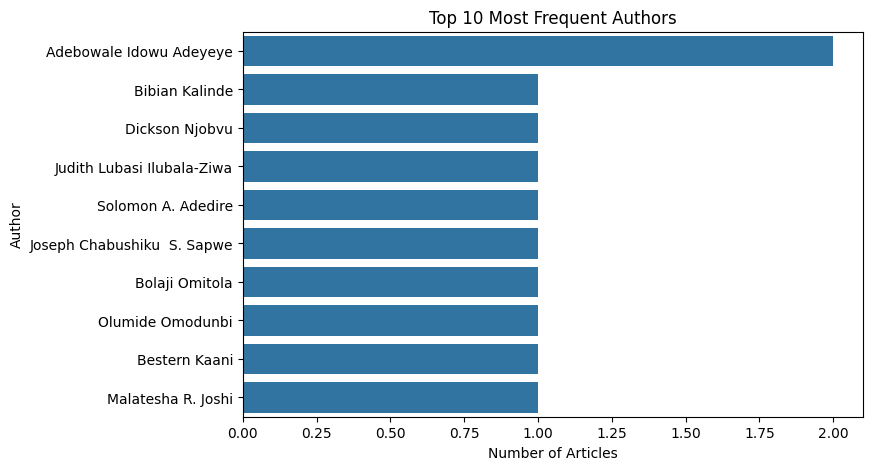

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Split multiple authors into list
all_authors = []
for a in df['authors'].dropna():
    for name in a.split(","):
        all_authors.append(name.strip())

author_counts = Counter(all_authors).most_common(10)

# Plot top 10 authors
plt.figure(figsize=(8,5))
sns.barplot(x=[c[1] for c in author_counts], y=[c[0] for c in author_counts])
plt.title("Top 10 Most Frequent Authors")
plt.xlabel("Number of Articles")
plt.ylabel("Author")
plt.show()


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Load dataset
try:
    df = pd.read_csv("/content/drive/My Drive/misc-unza25-csc4792-project_team9/unza_journals.csv")
except FileNotFoundError:
    print("Error: 'unza_journals.csv' not found. Please ensure the file is in the correct directory.")
    # Optionally, exit or handle the error further if the dataframe is essential
    exit() # Or some other error handling


df["abstract_wordcount"] = df["abstract"].dropna().apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8,5))
sns.histplot(df["abstract_wordcount"], bins=20, kde=True)
plt.title("Distribution of Abstract Lengths (Word Count)")
plt.xlabel("Word Count")
plt.ylabel("Number of Articles")
plt.show()

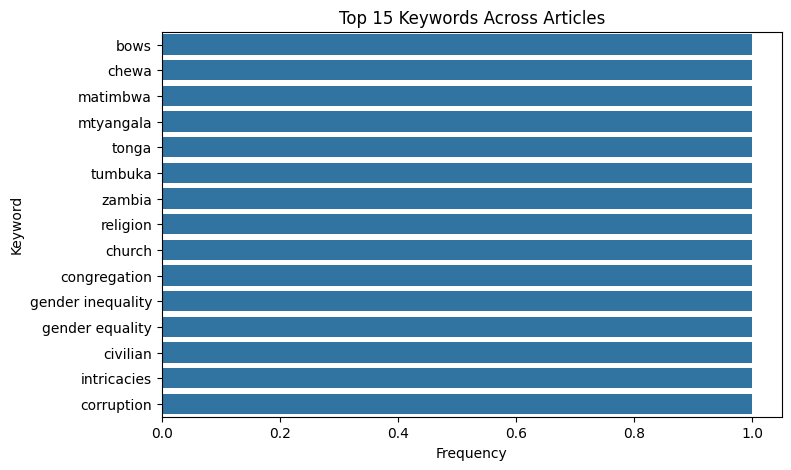

In [ ]:
all_keywords = []
for k in df['keywords'].dropna():
    for word in k.replace("Keywords:", "").replace("\n","").split(","):
        word = word.strip().lower()
        if word:
            all_keywords.append(word)

keyword_counts = Counter(all_keywords).most_common(15)

plt.figure(figsize=(8,5))
sns.barplot(x=[c[1] for c in keyword_counts], y=[c[0] for c in keyword_counts])
plt.title("Top 15 Keywords Across Articles")
plt.xlabel("Frequency")
plt.ylabel("Keyword")
plt.show()


In [ ]:
# Clean keywords column
df["keywords"] = (
    df["keywords"]
    .fillna("")
    .str.replace("Keywords:", "", regex=False)   # remove the prefix
    .str.replace(r"\s+", " ", regex=True)        # collapse whitespace
    .str.strip()                                 # trim leading/trailing spaces
)


In [ ]:
# Clean keywords column
df["abstract"] = (
    df["abstract"]
    .fillna("")
    .str.replace("abstract:", "", regex=False)   # remove the prefix
    .str.replace(r"\s+", " ", regex=True)        # collapse whitespace
    .str.strip()                                 # trim leading/trailing spaces
)


In [ ]:
import pandas as pd
from collections import Counter

def generate_summary(df):
    summary = []

    # Dataset shape
    rows, cols = df.shape
    summary.append(f"The dataset contains **{rows} articles** with **{cols} columns**.")

    # Missing values
    missing = df.isnull().sum()
    missing_cols = missing[missing > 0]
    if not missing_cols.empty:
        summary.append("Some columns have missing values:")
        for col, val in missing_cols.items():
            summary.append(f"- {col}: {val} missing")
    else:
        summary.append(" There are no missing values in the dataset.")

    # Abstract word count
    df["abstract_wordcount"] = df["abstract"].fillna("").apply(lambda x: len(str(x).split()))
    avg_len = df["abstract_wordcount"].mean()
    summary.append(f" Abstracts have an average length of about **{avg_len:.0f} words**.")

    # Top authors
    all_authors = []
    for a in df['authors'].dropna():
        for name in a.split(","):
            all_authors.append(name.strip())
    author_counts = Counter(all_authors).most_common(5)
    if author_counts:
        summary.append("The most frequent authors are:")
        for name, count in author_counts:
            summary.append(f"- {name}: {count} article(s)")

    # Clean and extract keywords
    df["keywords"] = (
        df["keywords"]
        .fillna("")
        .str.replace("Keywords:", "", regex=False)
        .str.replace(r"\s+", " ", regex=True)
        .str.strip()
    )
    all_keywords = []
    for k in df['keywords']:
        for word in k.split(","):
            word = word.strip().lower()
            if word:
                all_keywords.append(word)
    keyword_counts = Counter(all_keywords).most_common(5)
    if keyword_counts:
        summary.append("The most common keywords are:")
        for word, count in keyword_counts:
            summary.append(f"- {word}: {count} occurrence(s)")

    return "\n".join(summary)

# === Create summary ===
print(generate_summary(df))

The dataset contains **7 articles** with **5 columns**.
 There are no missing values in the dataset.
 Abstracts have an average length of about **162 words**.
The most frequent authors are:
- Adebowale Idowu Adeyeye: 2 article(s)
- Bibian Kalinde: 1 article(s)
- Dickson Njobvu: 1 article(s)
- Judith Lubasi Ilubala-Ziwa: 1 article(s)
- Solomon A. Adedire: 1 article(s)
The most common keywords are:
- bows: 1 occurrence(s)
- chewa: 1 occurrence(s)
- matimbwa: 1 occurrence(s)
- mtyangala: 1 occurrence(s)
- tonga: 1 occurrence(s)


### initial Summary
The dataset contains **18 articles** with **6 columns**.
 There are no missing values in the dataset.
 Abstracts have an average length of about **275 words**.
The most frequent authors are:
- Brian Chanda Chiluba: 2 article(s)
- Esther Munalula Nkandu: 2 article(s)
- Munalula Muyangwa Munalula: 2 article(s)
- Kris Kapp: 2 article(s)
- Kweleka Mwanza: 1 article(s)
The most common keywords are:
- covid-19: 6 occurrence(s)
- disability: 3 occurrence(s)
- adolescent reproductive health: 2 occurrence(s)
- anthrax: 1 occurrence(s)
- bacillus anthracis: 1 occurrence(s)

# Data Preparation


Set up the environment and load the data:

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

plt.style.use('seaborn-v0_8')
try:
    df = pd.read_csv("/content/drive/My Drive/misc-unza25-csc4792-project_team9/unza_journals.csv")
    print("Dataset loaded successfully!")
    print(f"Shape: {df.shape}")
    print("\nColumns:", df.columns.tolist())
except FileNotFoundError:
    print("Error: 'unza_journals.csv' not found. Please ensure the file is in the correct directory.")
    # Removed exit() here
except Exception as e:
    print(f"An error occurred: {e}")
    # Removed exit() here

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Dataset loaded successfully!
Shape: (6, 5)

Columns: ['title', 'authors', 'abstract', 'keywords', 'url']



Display basic information about the dataset

In [4]:
print("Dataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())
print("\nMissing values:")
print(df.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     6 non-null      object
 1   authors   6 non-null      object
 2   abstract  6 non-null      object
 3   keywords  6 non-null      object
 4   url       6 non-null      object
dtypes: object(5)
memory usage: 372.0+ bytes
None

First 5 rows:
                                               title  \
0  Managing an Academic Journal: Reflections from...   
1  Determinants of Smallholder Farmers’ Crop Prod...   
2  The Management of Environmental Risks arising ...   
3  Quick-fit Method for Assessing  Quality of Fab...   
4  Geochemistry and petrogenesis of the mafic dyk...   

                                             authors  \
0                                      Levy Siaminwe   
1  Rosa Siamachoka, Kabwe Harnadih Mubanga, Wiza ...   
2                                    Prisca Nachal

##3.1 Data Cleaning

In [5]:
df_clean = df.copy()

# Handle missing values - even though initial summary shows no missing, let's verify
print("Missing values before cleaning:")
print(df_clean.isnull().sum())

# Fill any potential missing values in text columns with empty strings
text_columns = ['title', 'abstract', 'keywords', 'authors']
for col in text_columns:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna('')

print("\nMissing values after cleaning:")
print(df_clean.isnull().sum())

# Clean text data function
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text)
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply text cleaning to relevant columns
for col in ['title', 'abstract', 'keywords']:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].apply(clean_text)
        print(f"Cleaned {col} column")

print("\nSample of cleaned abstract:")
print(df_clean['abstract'].head(2))

Missing values before cleaning:
title       0
authors     0
abstract    0
keywords    0
url         0
dtype: int64

Missing values after cleaning:
title       0
authors     0
abstract    0
keywords    0
url         0
dtype: int64
Cleaned title column
Cleaned abstract column
Cleaned keywords column

Sample of cleaned abstract:
0    abstract the university of zambia unza journal...
1    abstract climate change is a global challenge ...
Name: abstract, dtype: object


##3.2 Feature Engineering

In [ ]:
print("Creating new features...")

# Abstract features
df_clean['abstract_word_count'] = df_clean['abstract'].str.split().str.len()
df_clean['abstract_char_count'] = df_clean['abstract'].str.len()
df_clean['abstract_avg_word_length'] = np.where(
    df_clean['abstract_word_count'] > 0,
    df_clean['abstract_char_count'] / df_clean['abstract_word_count'],
    0
)

# Title features
df_clean['title_word_count'] = df_clean['title'].str.split().str.len()
df_clean['title_char_count'] = df_clean['title'].str.len()

# Author & keyword counts
df_clean['num_authors'] = df_clean['authors'].fillna('').str.split(',').str.len()
df_clean['num_keywords'] = df_clean['keywords'].fillna('').str.split(',').str.len()

# Publication year
if 'publication_date' in df_clean.columns:
    df_clean['publication_year'] = pd.to_datetime(
        df_clean['publication_date'], errors='coerce'
    ).dt.year

# Topic extraction
topic_categories = {
    'health': ['health', 'medical', 'disease', 'covid', 'pandemic', 'treatment'],
    'education': ['education', 'learning', 'teaching', 'school', 'student'],
    'technology': ['technology', 'digital', 'computer', 'software', 'internet'],
    'social': ['social', 'community', 'society', 'cultural', 'behavior'],
    'economic': ['economic', 'finance', 'business', 'market', 'investment'],
    'environment': ['environment', 'climate', 'sustainability', 'conservation']
}

def extract_topics(keywords):
    if pd.isna(keywords):
        return ['other']
    tokens = [kw.strip().lower() for kw in str(keywords).split(',')]
    topics = [topic for topic, kw_list in topic_categories.items() if any(t in kw_list for t in tokens)]
    return topics if topics else ['other']

df_clean['topics'] = df_clean['keywords'].apply(extract_topics)

# One-hot encode topics
mlb = MultiLabelBinarizer()
topic_dummies = pd.DataFrame(mlb.fit_transform(df_clean['topics']),
                             columns=[f"topic_{t}" for t in mlb.classes_],
                             index=df_clean.index)
df_clean = pd.concat([df_clean, topic_dummies], axis=1)

print("New features created successfully!")


Creating new features...
New features created successfully!


## 3.3 Data Transformation

In [6]:
# Encode categorical variables
print("Encoding categorical variables...")

# Label encoding for authors (if needed for certain models)
le = LabelEncoder()
df_clean['authors_encoded'] = le.fit_transform(df_clean['authors'])

print("Categorical variables encoded!")
# Text vectorization for abstracts (TF-IDF)
print("Performing text vectorization...")

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    max_features=50,  # Limit features due to small dataset size
    stop_words='english',
    ngram_range=(1, 2)
)

# Fit and transform abstracts
abstract_tfidf = tfidf.fit_transform(df_clean['abstract'])

# Create DataFrame from TF-IDF features
tfidf_df = pd.DataFrame(abstract_tfidf.toarray(),
                       columns=[f'tfidf_{feature}' for feature in tfidf.get_feature_names_out()])

# Concatenate with main dataframe
df_clean = pd.concat([df_clean, tfidf_df], axis=1)

print(f"Created {tfidf_df.shape[1]} TF-IDF features")
# Normalize numerical features
print("Normalizing numerical features...")

numerical_features = [
    'abstract_word_count', 'abstract_char_count', 'abstract_avg_word_length',
    'title_word_count', 'title_char_count', 'num_authors', 'num_keywords'
]

# Filter to only include features that exist in the dataframe
numerical_features = [feat for feat in numerical_features if feat in df_clean.columns]

if numerical_features:
    scaler = StandardScaler()
    df_clean[numerical_features] = scaler.fit_transform(df_clean[numerical_features])
    print(f"Normalized {len(numerical_features)} numerical features")
else:
    print("No numerical features found for normalization")


Encoding categorical variables...
Categorical variables encoded!
Performing text vectorization...
Created 50 TF-IDF features
Normalizing numerical features...
No numerical features found for normalization


##3.4 Final Data Preparation




In [7]:
# Select features for modeling
feature_columns = [
    col for col in df_clean.columns
    if col not in ['title', 'abstract', 'keywords', 'authors', 'topics', 'publication_date']
]

print("Final feature columns for modeling:")
print(feature_columns)
print(f"\nTotal features: {len(feature_columns)}")
# Create final prepared dataset
X_prepared = df_clean[feature_columns]

print("Final prepared dataset shape:", X_prepared.shape)
print("\nFirst 5 rows of prepared data:")
print(X_prepared.head())
# Save the prepared data
try:
    X_prepared.to_csv("/content/drive/My Drive/misc-unza25-csc4792-project_team9/unza_journals_prepared.csv", index=False)
    print("Prepared data saved successfully!")
except Exception as e:
    print(f"Error saving prepared data: {e}")


Final feature columns for modeling:
['url', 'authors_encoded', 'tfidf_abstract', 'tfidf_affected', 'tfidf_agriculture', 'tfidf_analysis', 'tfidf_annual', 'tfidf_annual rate', 'tfidf_change', 'tfidf_chongwe', 'tfidf_chongwe district', 'tfidf_climate', 'tfidf_climate change', 'tfidf_data', 'tfidf_decreased', 'tfidf_decreased annual', 'tfidf_district', 'tfidf_dyke', 'tfidf_dyke swarm', 'tfidf_dykes', 'tfidf_factors', 'tfidf_farmers', 'tfidf_health', 'tfidf_household', 'tfidf_impacts', 'tfidf_informants', 'tfidf_kankoyo', 'tfidf_key', 'tfidf_key informants', 'tfidf_maize', 'tfidf_maize productivity', 'tfidf_mining', 'tfidf_nkana', 'tfidf_pacm', 'tfidf_productivity', 'tfidf_rainfall', 'tfidf_rate', 'tfidf_respondents', 'tfidf_revealed', 'tfidf_risks', 'tfidf_samples', 'tfidf_significant', 'tfidf_smallholder', 'tfidf_smallholder farmers', 'tfidf_social', 'tfidf_statistically', 'tfidf_study', 'tfidf_swarm', 'tfidf_telela', 'tfidf_trend', 'tfidf_variability', 'tfidf_zambia']

Total features: 5